In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd
import xarray as xr
import glob
import utils
import scipy.stats as stats
import faceted as faceted

/home/tarshish/micromamba/envs/zec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.set_plot_configs(plt, fsize=8)

In [3]:
results_dir = utils.get_path('results')
datasets_dir = utils.get_path('datasets')

In [50]:
ds_co2 = xr.open_mfdataset(results_dir+"/fair/*_co2_*zec.nc").temperature.isel(layer=0).median("config").compute()

In [51]:
ds_all = xr.open_mfdataset(results_dir+"/fair/*_all_*zec.nc").temperature.isel(layer=0).median("config").compute()

In [6]:
ds_net_zero = xr.open_mfdataset(results_dir+"/fair/*_net-zero-zec.nc").temperature.isel(layer=0).median("config").compute()

In [52]:
ds_co2 = ds_co2.drop_sel(scenario="ssp434")
ds_all = ds_all.drop_sel(scenario="ssp434")

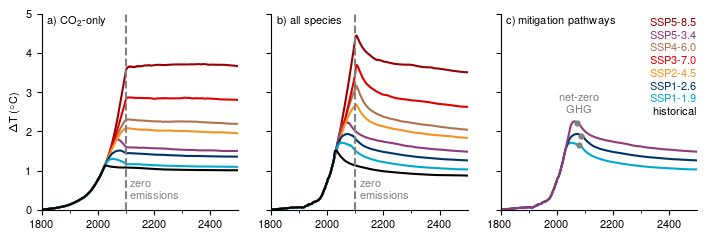

In [166]:
markersize = 12
markershape = "o"
linewidth=1.5

fig, axes = faceted.faceted(1,3,sharex=True,width=7, 
                            aspect=1.0, sharey=True,
                           left_pad=.35, right_pad=.1,
                           top_pad=.1)

for scenario in ds_co2.scenario[::-1]:
    d = ds_co2.sel(scenario=scenario)
    axes[0].plot(d.timebound, d.values, color=utils.get_color(scenario.item()), zorder=0)

axes[0].axvline(2100, color="grey", linestyle="dashed", zorder=3)
axes[0].text(2115, .3, "zero \n emissions", ha="left", color="grey")

for scenario in ds_all.scenario[::-1]:
    d = ds_all.sel(scenario=scenario)
    axes[1].plot(d.timebound, d.values, color=utils.get_color(scenario.item()), zorder=0,
                label=utils.get_title(scenario.item()))


for scenario in ds_net_zero.scenario:
    d = ds_net_zero.sel(scenario=scenario)
    axes[2].plot(d.timebound, d.values, color=utils.get_color(scenario.item()), zorder=0)
    
    net_zero_time = utils.get_net_zero_GHG_time(scenario.item())
    axes[2].scatter(net_zero_time-.5,
                d.sel(timebound=net_zero_time-.5),
                zorder=5, color="grey", 
                marker=markershape, s=markersize)
    
    # axes[2].axvline(net_zero_time-.5, color=utils.get_color(scenario.item()), linestyle="dashed", zorder=3)

    
axes[1].axvline(2100, color="grey", linestyle="dashed", zorder=3)
axes[1].text(2115, .3, "zero \n emissions", ha="left", color="grey")

# d = ds.sel(scenario=scenario)
#     ax1.plot(d.timebound, median.sel(scenario=scenario), color=utils.get_color(scenario.item()), zorder=0,
#              linewidth=linewidth, label=utils.get_title(scenario.item()))

#axes[1].legend()

for ax in axes:
    ax.set_xlim([1800,2500])
    ax.set_ylim([0,5])
    ax.set_xticks(np.arange(1900, 2500, 100), minor=True)


titles = ["a) CO$_2$-only", "b) all species", "c) mitigation pathways"]
for title, ax in zip(titles, axes):
    ax.text(1820, 4.8, title, ha="left", va="center")

axes[0].set_ylabel(r"$\Delta$T (${}^\circ$C)")

axes[2].text(2080, 2.7, "net-zero\nGHG", ha="center", va="center", color="grey")


for scenario, yheight in zip(ds_all.scenario, np.linspace(2.5,5.1,9)):
    axes[2].text(2500, yheight, utils.get_title(scenario.item()), 
                 color=utils.get_color(scenario.item()),
                 ha="right",
                 va="center") 

sns.despine()
fig.savefig(results_dir+"/figures/fig_3.pdf")